MOUNTING DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')

In [7]:
!pip install sentencepiece transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 26.6 MB/s 
     |████████████████████████████████| 4.7 MB 56.5 MB/s 
     |████████████████████████████████| 6.6 MB 58.9 MB/s 
     |████████████████████████████████| 120 kB 77.8 MB/s 


<h2>1. BUSINESS PROBLEM</h2>

<h3>DESCRIPTION</h3>

Computers are really good at answering questions with single, verifiable answers. But, humans are often still better at answering questions about opinions, recommendations, or personal experiences.

Humans are better at addressing subjective questions that require a deeper, multidimensional understanding of context - something computers aren't trained to do well…yet.. Questions can take many forms - some have multi-sentence elaborations, others may be simple curiosity or a fully developed problem. They can have multiple intents, or seek advice and opinions. Some may be helpful and others interesting. Some are simple right or wrong.
<br>
<img src="https://storage.googleapis.com/kaggle-media/competitions/google-research/human_computable_dimensions_1.png" width="700" height="800">
<br>
Unfortunately, it’s hard to build better subjective question-answering algorithms because of a lack of data and predictive models. That’s why the CrowdSource team at Google Research, a group dedicated to advancing NLP and other types of ML science via crowdsourcing, has collected data on a number of these quality scoring aspects.

In this competition, you’re challenged to use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion. Our raters received minimal guidance and training, and relied largely on their subjective interpretation of the prompts. As such, each prompt was crafted in the most intuitive fashion so that raters could simply use their common-sense to complete the task. By lessening our dependency on complicated and opaque rating guidelines, we hope to increase the re-use value of this data set. What you see is what you get!

Demonstrating these subjective labels can be predicted reliably can shine a new light on this research area. Results from this competition will inform the way future intelligent Q&A systems will get built, hopefully contributing to them becoming more human-like.



<h3>PROBLEM STATEMENT</h3>

1. Computers are generally considered good at answering questions that are of a factual nature meaning questions for which there exists only single, verifiable answer unlike subjective questions where a deeper, multidimensional understanding of the context is required. Answers to such questions usually are not definitive in nature and changes based on how an individual comprehends it.

2. Google research team has collected data from 70 different websites used raters to answer each of the 30 prompts where 21 prompts are related to questions asked and 9 related to answers corresponding to it.

3. Our task as an ML Engineer is to design a model that can reliably predict each of these 30 different subjective lables.

<h3>BUSINESS OBJECTIVES & CONSTRAINTS</h3>

1. Reliable prediction of these subjective label is desired as it would taking us one step closer to our desire of making feature models more and more human like.

2. Since each of the prompts being answered takes a value between 0 and 1 and value corresponding to each prompt depicts the chances of presence of that subjective aspect in our question and answer.so, we need to have a model that would give us the probability scores for each of the target labels.

3. No strict latency requirement is there for this particular problem.

4. Higher interpretability of the model is desired to understand the decision making process of the model which can help us ascertain the sanity of the model.

<h2>2. MAPPING BUSINESS PROBLEM TO A ML PROBLEM</h2>

<h3>DATA OVERVIEW</h3>

1. Data for solving the problem is there in a 13.76 MB file train.csv with each datapoint having 11 input labels and 30 target labels with target labels being present in the last 30 columns

2. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

3. Each row contains a single question and a single answer to that question, along with additional features. The training data contains rows with some duplicated questions (but with different answers).

<h3>TYPE OF ML PROBLEM</h3>

It's a REGRESSION problem where the task is to predict 30 Target Labels for each question answer pair in the given dataset.

<h3>PERFORMANCE METRICS</h3>

1. MEAN SQUARED ERROR - Since it's a regression problem which makes MSE an ideal choice of loss function for this particular business problem.

2. LOG LOSS - Since log loss is equipped to work with the probabilty scores and the target label in this particular can only assume any value between 0 & 1  only. So, log loss can also be a choice of loss function for this business problem.

3. SPEARMAN's CORRELATION COEFFICIENT -  Spearman's rank correlation is computed for each target column, and the mean of these values is calculated to evaluate the performance

<h3>TRAIN & CV SET CONSTRUCTION</h3>

Since the features being used are broadly of a NON-TEMPORAL nature. So, for such problem statements RANDOM SPLITTING is the stratergy we should opt for.

In [8]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM, GlobalAveragePooling1D
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig

<h2>3. DATA ACQUISITION</h2>

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/google-quest-challenge/train.csv')
data.head() 

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


<h2>4. EXPLORATORY DATA ANALYSIS</h2>

In [ ]:
print('LIST OF INPUT VARIABLES')
for i, column in enumerate(data.columns[:11]):
    print(i+1, column)

print('\nLIST OF TARGET VARIABLES')
for i, column in enumerate(data.columns[11:]):
    print(i+1, column)

LIST OF INPUT VARIABLES
1 qa_id
2 question_title
3 question_body
4 question_user_name
5 question_user_page
6 answer
7 answer_user_name
8 answer_user_page
9 url
10 category
11 host

LIST OF TARGET VARIABLES
1 question_asker_intent_understanding
2 question_body_critical
3 question_conversational
4 question_expect_short_answer
5 question_fact_seeking
6 question_has_commonly_accepted_answer
7 question_interestingness_others
8 question_interestingness_self
9 question_multi_intent
10 question_not_really_a_question
11 question_opinion_seeking
12 question_type_choice
13 question_type_compare
14 question_type_consequence
15 question_type_definition
16 question_type_entity
17 question_type_instructions
18 question_type_procedure
19 question_type_reason_explanation
20 question_type_spelling
21 question_well_written
22 answer_helpful
23 answer_level_of_information
24 answer_plausible
25 answer_relevance
26 answer_satisfaction
27 answer_type_instructions
28 answer_type_procedure
29 answer_type_reas

<h3>Number of unique questions in the dataset?</h3>

In [ ]:
print("Total number of unique questions in the training dataset = ", len(data['question_title'].unique()))

Total number of unique questions in the training dataset =  3583


<h3>QUESTION TITLE</h3>

In [ ]:
question_title_length = data['question_title'].apply(lambda x: len(x.split(' ')))

In [ ]:
question_title_length.describe()

count    6079.000000
mean        9.035861
std         3.775760
min         2.000000
25%         6.000000
50%         9.000000
75%        11.000000
max        28.000000
Name: question_title, dtype: float64

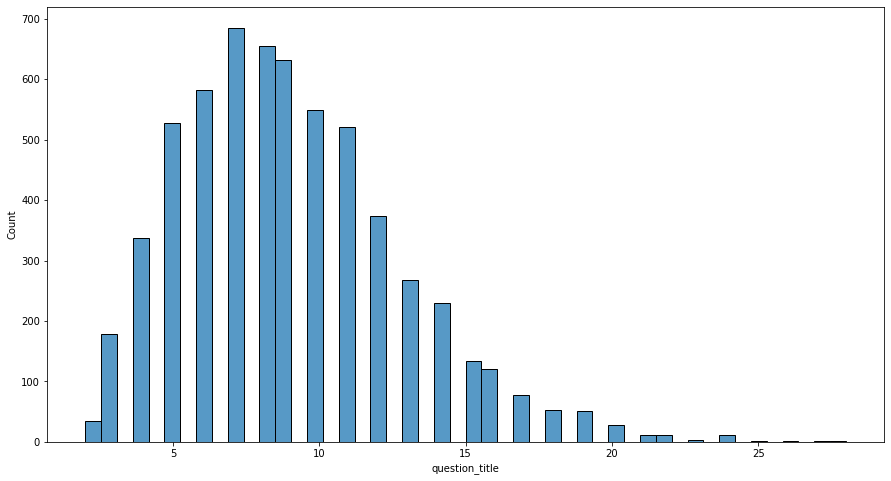

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.histplot(x = question_title_length)

OBSERVATIONS:
1. The distribution seems to look like a right skewed distribution.
2. 50% of the question lengths vary between 6 - 11 words with 9 words as a mean length for question title.

<h3>QUESTION BODY</h3>

In [ ]:
question_body_length = data['question_body'].apply(lambda x: len(x.split(' ')))

In [ ]:
question_body_length.describe()

count    6079.000000
mean      150.440204
std       228.709619
min         1.000000
25%        55.000000
50%        93.000000
75%       165.000000
max      4666.000000
Name: question_body, dtype: float64

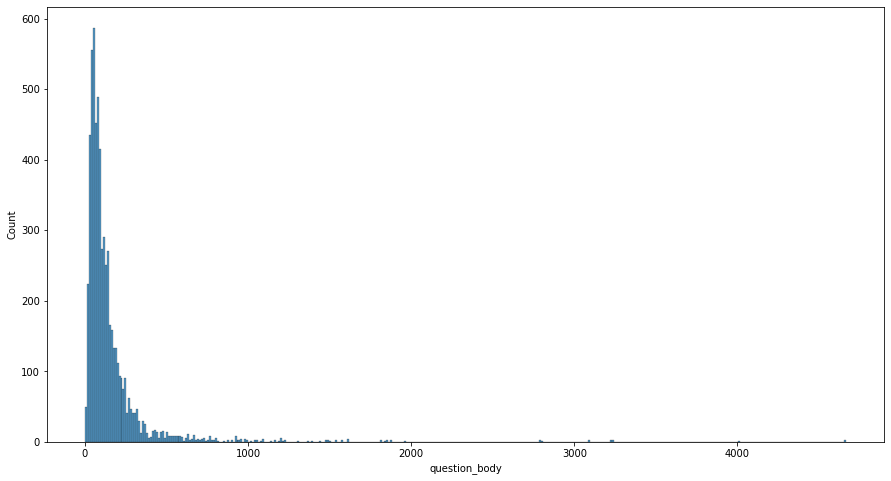

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.histplot(x = question_body_length)

OBSERVATIONS: 
1. The distribution seems to look like a Pareto Curve with 75% users describing questions in not more than 165 words.
2. 50% of the question lengths vary between 55 - 165 words with 150 words as a mean length for question title.

<h3>QUESTION USER NAME</h3>

In [ ]:
questions_asked_by_user = data.groupby(by = ['question_user_name'])['question_user_name'].count()

In [ ]:
questions_asked_by_user.describe()

count    3215.000000
mean        1.890824
std         1.236587
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        15.000000
Name: question_user_name, dtype: float64

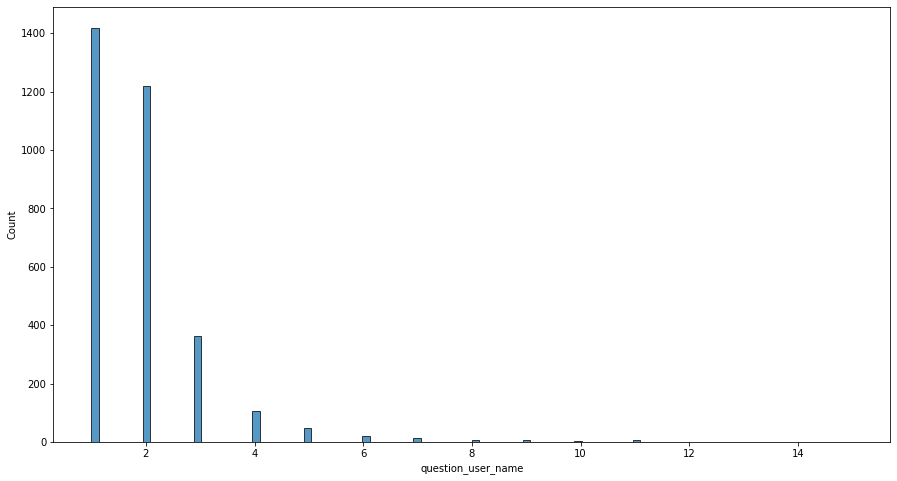

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.histplot(x = questions_asked_by_user)

OBSERVATIONS:
1. The question asked by each user also seems to follow Pareto distribution with 75% of the users not asking more than 2 questions and only a very few amongst all the users asking questions more than 4 times.

<h3>ANSWER</h3>

In [ ]:
answer_length = data['answer'].apply(lambda x: len(x.split(' ')))

In [ ]:
answer_length.describe()

count    6079.000000
mean      143.708834
std       205.933584
min         2.000000
25%        48.000000
50%        91.000000
75%       170.000000
max      8158.000000
Name: answer, dtype: float64

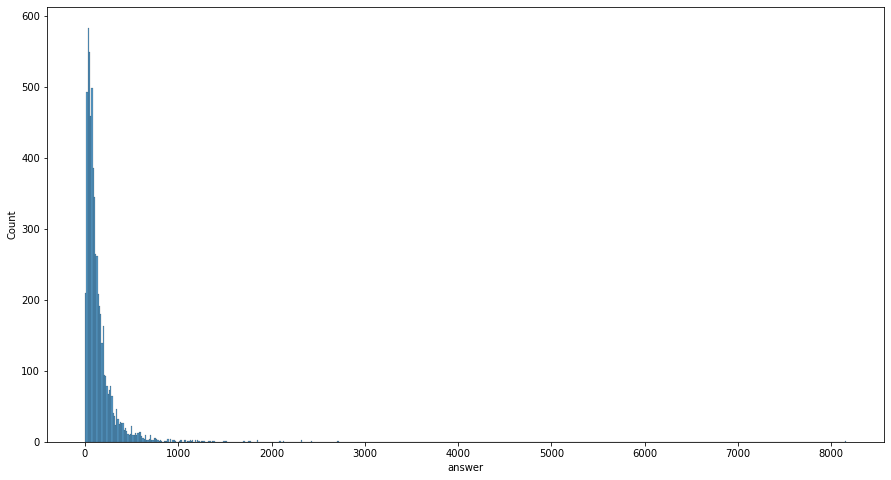

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.histplot(x = answer_length)

OBSERVATIONS:

1. The distribution seems to look like a Pareto Curve with 75% users answering questions in not more than 170 words.
2. 50% of the answer lengths vary between 48 - 170 words with 143 words as a mean length for answers.

<h3>ANSWER USER NAME</h3>

In [ ]:
questions_answered_by_user = data.groupby(by = ['answer_user_name'])['answer_user_name'].count()

In [ ]:
questions_answered_by_user.describe()

count    4114.000000
mean        1.477637
std         1.319074
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        20.000000
Name: answer_user_name, dtype: float64

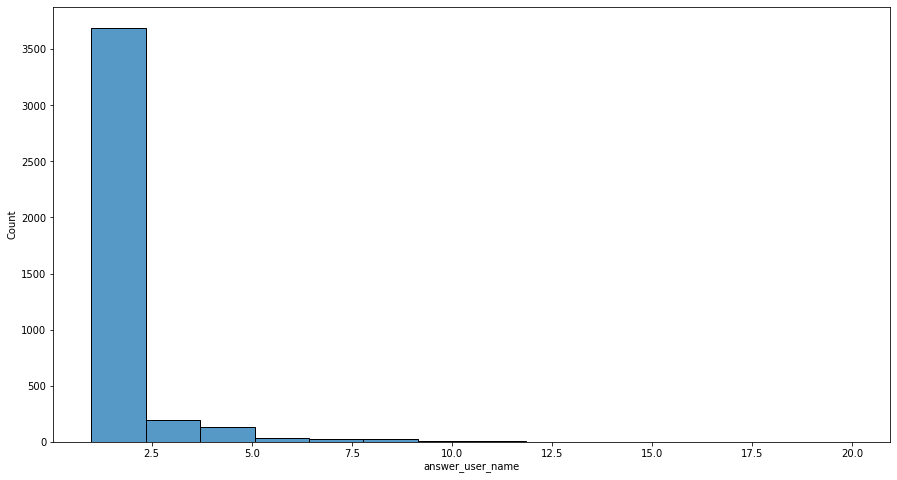

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.histplot(x = questions_answered_by_user)

OBSERVATIONS:
1. Distribution of question answering pattern seems to follow a pareto curve with 75% of the users not answering more than 1 question and there exist very few users who have answered more than 5 times.

<h3>CATEGORY</h3>

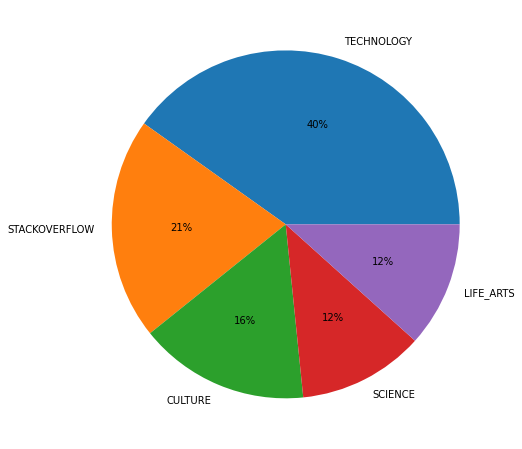

In [ ]:
plt.figure(figsize=(15,8))
palette_color = sns.color_palette()
plt.pie(data['category'].value_counts(), labels=data['category'].value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

OBSERVATIONS:
1. The questions in the given dataset have been divided amongst 5 categories Technology, Stackoverflow, Culture, Science and Life Arts.
2. Maximum amount of questions in the data corpus belong to Technology (40%).
3. Science and Life Arts contributing the least to the data corpus. 

<h3>HOST</h3>

In [ ]:
hosts = data['host'].value_counts()

In [ ]:
hosts.describe()

count      63.000000
mean       96.492063
std       157.675542
min         2.000000
25%        41.000000
50%        71.000000
75%       100.000000
max      1253.000000
Name: host, dtype: float64

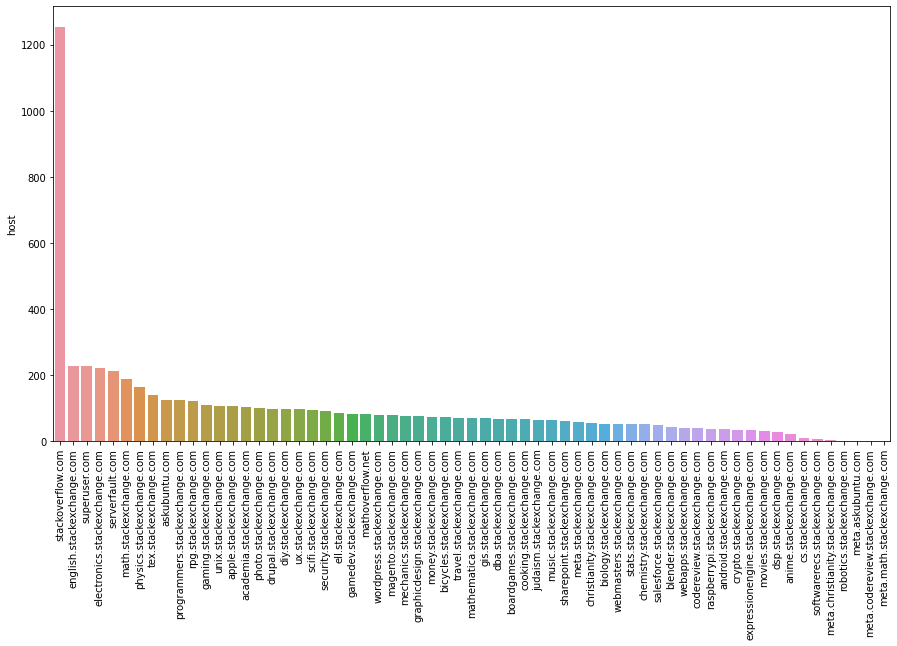

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x = hosts.index, y = hosts)
ax.set_xticklabels(labels = hosts.index,rotation=90)
plt.show()

<h3>DISTRIBUTION & CORRELATION OF TARGET VARIABLES</h3>

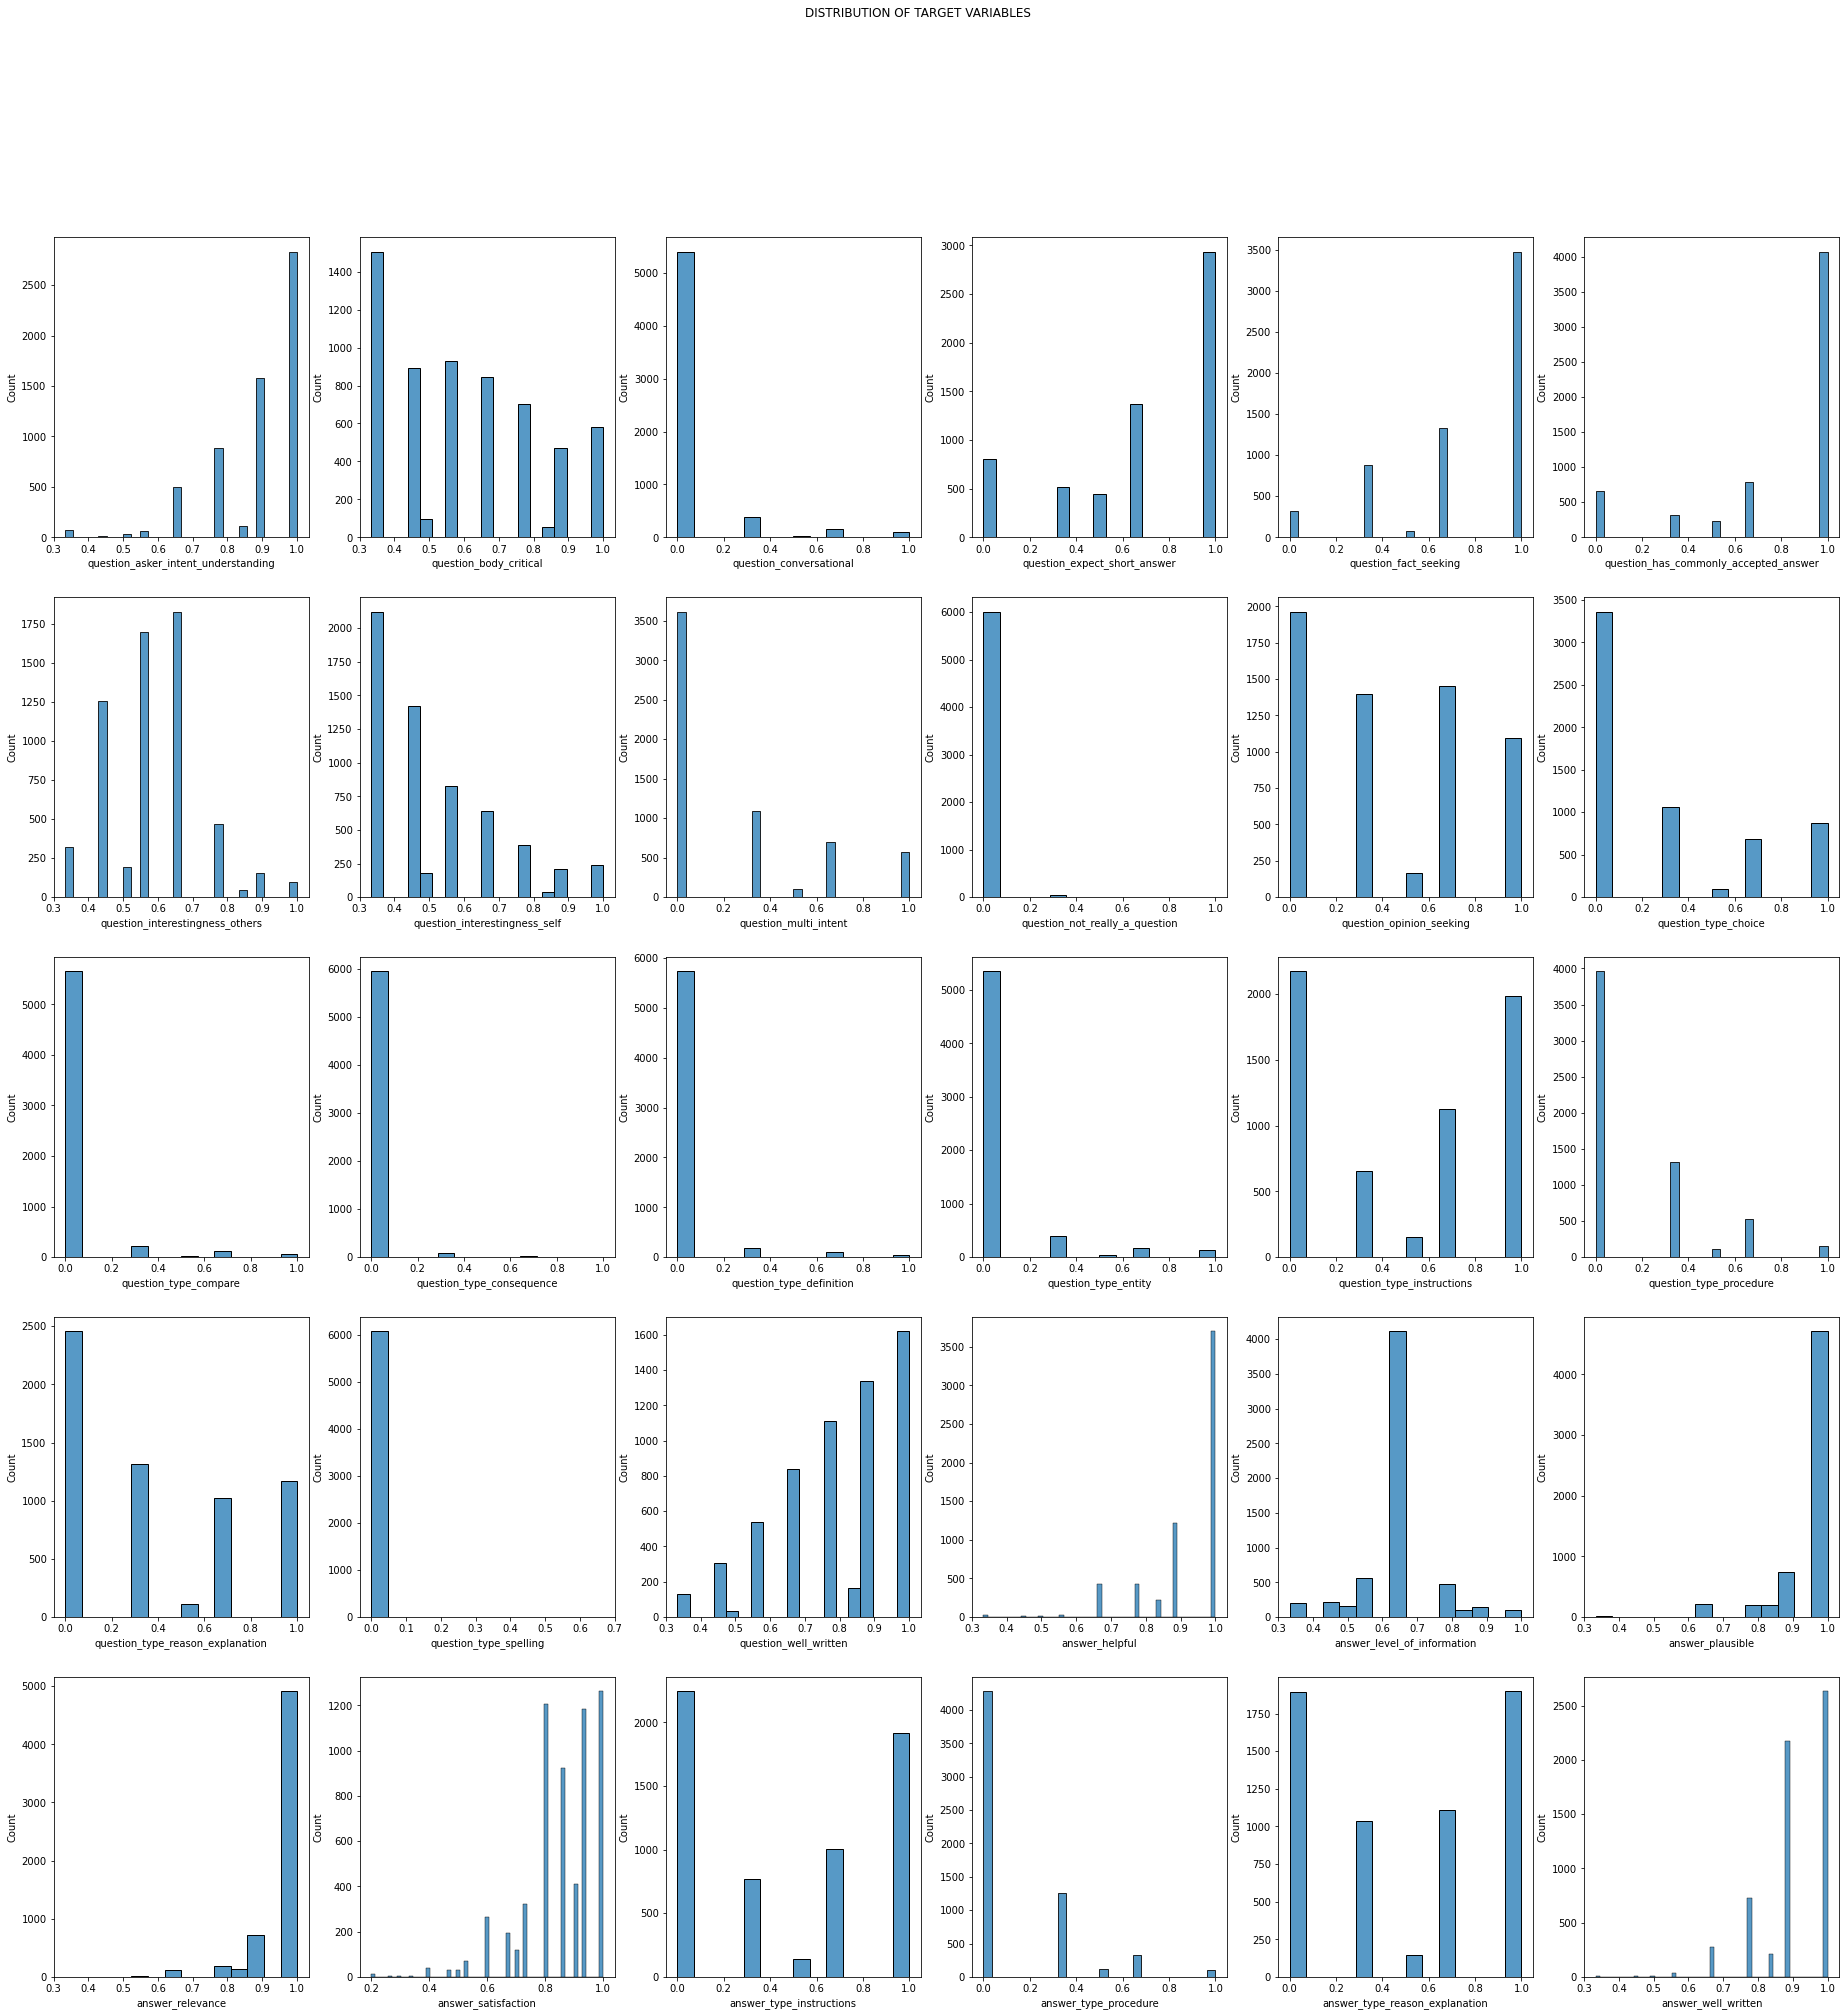

In [ ]:
fig,ax  = plt.subplots(5,6, figsize = (32,32))
fig.suptitle('DISTRIBUTION OF TARGET VARIABLES')
for axes,label in zip(ax.flatten(),data.columns[11:]):
    sns.histplot(ax = axes, x = label, data = data)

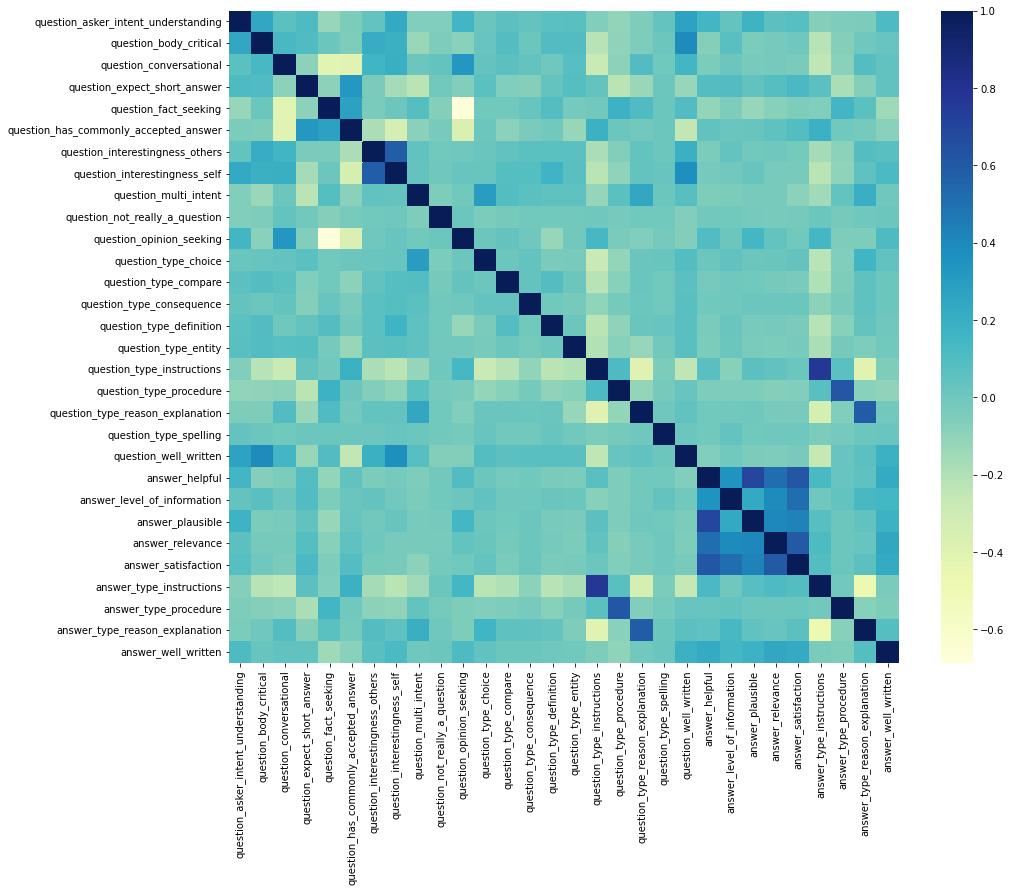

In [ ]:
plt.figure(figsize=(15,12))
target_variables = data.columns[11:]
dataplot = sns.heatmap(data.loc[:,target_variables].corr(), cmap="YlGnBu")

<h2>5. FEATURE ENGINEERING & SELECTION</h2>

<h3>PREPOCESS TEXT FEATURES</h3>

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase

def preprocess(text):
    """
    this function performs the preprocessing on the text by converting to lower case, removing html tags, preform decontractions,
    remove special characters from the input text
    """
    preprocessed_text = text
    preprocessed_text = preprocessed_text.lower()
    preprocessed_text = re.sub('<[^>]*>','',preprocessed_text)
    preprocessed_text = decontractions(preprocessed_text)
    preprocessed_text = re.sub('[^A-Za-z0-9 ]+', ' ', preprocessed_text)
    preprocessed_text = re.sub(' +', ' ', preprocessed_text)
    return preprocessed_text


In [ ]:
data['question_title'] = data['question_title'].apply(preprocess)
data['question_body'] = data['question_body'].apply(preprocess)
data['answer'] = data['answer'].apply(preprocess)

<h3>PREPARING DATASETS</h3>

In [ ]:
question_title_length = data['question_title'].apply(len)
question_body_length = data['question_body'].apply(len)
answer_length = data['answer'].apply(len)

In [ ]:
print("QUESTION TITLE LENGTH\n\n")
for x in np.arange(99,100,0.1):
    print(f"{x} percentile sequence lengths are less than {np.percentile(question_title_length,x)}")
    
print("\n\nQUESTION BODY LENGTH\n\n")
for x in np.arange(99,100,0.1):
    print(f"{x} percentile sequence lengths are less than {np.percentile(question_body_length,x)}")
    
print("\n\nANSWER LENGTH\n\n")
for x in np.arange(99,100,0.1):
    print(f"{x} percentile sequence lengths are less than {np.percentile(answer_length,x)}")

QUESTION TITLE LENGTH


99.0 percentile sequence lengths are less than 111.0
99.1 percentile sequence lengths are less than 111.29799999999977
99.19999999999999 percentile sequence lengths are less than 113.0
99.29999999999998 percentile sequence lengths are less than 114.0
99.39999999999998 percentile sequence lengths are less than 117.0
99.49999999999997 percentile sequence lengths are less than 119.21999999999571
99.59999999999997 percentile sequence lengths are less than 121.0
99.69999999999996 percentile sequence lengths are less than 122.0
99.79999999999995 percentile sequence lengths are less than 129.68799999999464
99.89999999999995 percentile sequence lengths are less than 131.92199999999684


QUESTION BODY LENGTH


99.0 percentile sequence lengths are less than 4077.680000000011
99.1 percentile sequence lengths are less than 4375.389999999988
99.19999999999999 percentile sequence lengths are less than 4596.0
99.29999999999998 percentile sequence lengths are less than 4598.269

In [ ]:
max_seq_length = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

<h3>DATASET 1 : (QUESTION_TITLE + QUESTION_BODY + ANSWER)</h3>

In [ ]:
def prepare_question_answer_string(question_title, question_body, answer, tokenizer ,max_question_length = 254,max_answer_length = 254):
  question = question_title + question_body
  question = tokenizer.tokenize(question)
  answer = tokenizer.tokenize(answer)
  if len(question) >= max_question_length and len(answer) >= max_answer_length:
    new_max_length_question = int(max_question_length / 2)
    question = question[:new_max_length_question] + question[-new_max_length_question:]
    new_max_length_answer = int(max_answer_length / 2)
    answer = answer[:new_max_length_answer] + answer[-new_max_length_answer:]
  elif len(question) < max_question_length and len(answer) < max_answer_length:
    pass
  elif len(question) < max_question_length and len(answer) >= max_answer_length:
    max_answer_length = max_answer_length + (max_question_length - len(question))
    new_max_length_answer = int(max_answer_length / 2)
    answer = answer[:new_max_length_answer] + answer[-new_max_length_answer:]
  elif len(question) >= max_question_length and len(answer) < max_answer_length:
    max_question_length = max_question_length + (max_answer_length - len(answer))
    new_max_length_question = int(max_question_length / 2)
    question = question[:new_max_length_question] + question[-new_max_length_question:]

  return question, answer

def transform_dataset_1(question_title, question_body, answer, tokenizer, max_sequence_length = 512):
  question_tokens, answer_tokens = prepare_question_answer_string(question_title, question_body, answer, tokenizer)
  input_tokens = ['[CLS]'] + question_tokens + ['[SEP]'] + answer_tokens + ['[SEP]'] + ['[PAD]'] * (max_sequence_length - (len(question_tokens) + len(answer_tokens) + 3))
  input_sequence = tokenizer.convert_tokens_to_ids(input_tokens)
  mask_sequence = [1] * ((len(question_tokens) + len(answer_tokens) + 3)) + [0] * (max_sequence_length - (len(question_tokens) + len(answer_tokens) + 3))
  segmentation_sequence = [0] * (len(question_tokens) + 2) + [1] * (len(answer_tokens) + 1) + [0] * (max_sequence_length - (len(question_tokens) + len(answer_tokens) + 3))
  return np.array(input_sequence), np.array(mask_sequence), np.array(segmentation_sequence)


<strong>DATASET 1 INPUT SEQUENCES</strong>

In [ ]:
input,mask,segment = [],[],[]
for question_title, question_body , answer in tqdm(zip(data["question_title"].values, data["question_body"].values, data["answer"].values)):
  input_sequence, mask_sequences, segmentation_sequence = transform_dataset_1(question_title, question_body , answer, tokenizer)
  input.append(input_sequence)
  mask.append(mask_sequences)
  segment.append(segmentation_sequence)

input_dataset_1 = np.array(input)
mask_dataset_1 = np.array(mask)
segment_dataset_1 = np.array(segment)
input_dataset_1.shape, mask_dataset_1.shape, segment_dataset_1.shape

6079it [00:47, 128.08it/s]


((6079, 512), (6079, 512), (6079, 512))

<h3>DATASET 2 : (QUESTION_TITLE + QUESTION_BODY)</h3>

In [ ]:
def prepare_question_string(question_title, question_body, tokenizer,max_question_length = 510):
  question = question_title + question_body
  question = tokenizer.tokenize(question)
  if len(question) > max_question_length:
    question = question[:max_question_length]
  return question

def transform_dataset_2(question_title, question_body , tokenizer, max_sequence_length = 512):
  question_tokens = prepare_question_string(question_title, question_body, tokenizer)
  input_tokens = ['[CLS]'] + question_tokens + ['[SEP]'] + ['[PAD]'] * (max_sequence_length - (len(question_tokens)  + 2))
  input_sequence = tokenizer.convert_tokens_to_ids(input_tokens)
  mask_sequence = [1] * ((len(question_tokens) + 2)) + [0] * (max_sequence_length - (len(question_tokens) + 2))
  segmentation_sequence = [0] * (len(question_tokens) + 2) + [0] * (max_sequence_length - (len(question_tokens) + 2))
  return np.array(input_sequence), np.array(mask_sequence), np.array(segmentation_sequence)


<strong>DATASET 2 INPUT SEQUENCES</strong>

In [ ]:
input_question,mask_question,segment_question = [],[],[]
for question_title, question_body in tqdm(zip(data["question_title"].values, data["question_body"].values)):
  input_sequence, mask_sequences, segmentation_sequence = transform_dataset_2(question_title, question_body , tokenizer)
  input_question.append(input_sequence)
  mask_question.append(mask_sequences)
  segment_question.append(segmentation_sequence)

input_dataset_2 = np.array(input_question)
mask_dataset_2 = np.array(mask_question)
segment_dataset_2 = np.array(segment_question)
input_dataset_2.shape, mask_dataset_2.shape, segment_dataset_2.shape

6079it [00:26, 228.72it/s]


((6079, 512), (6079, 512), (6079, 512))

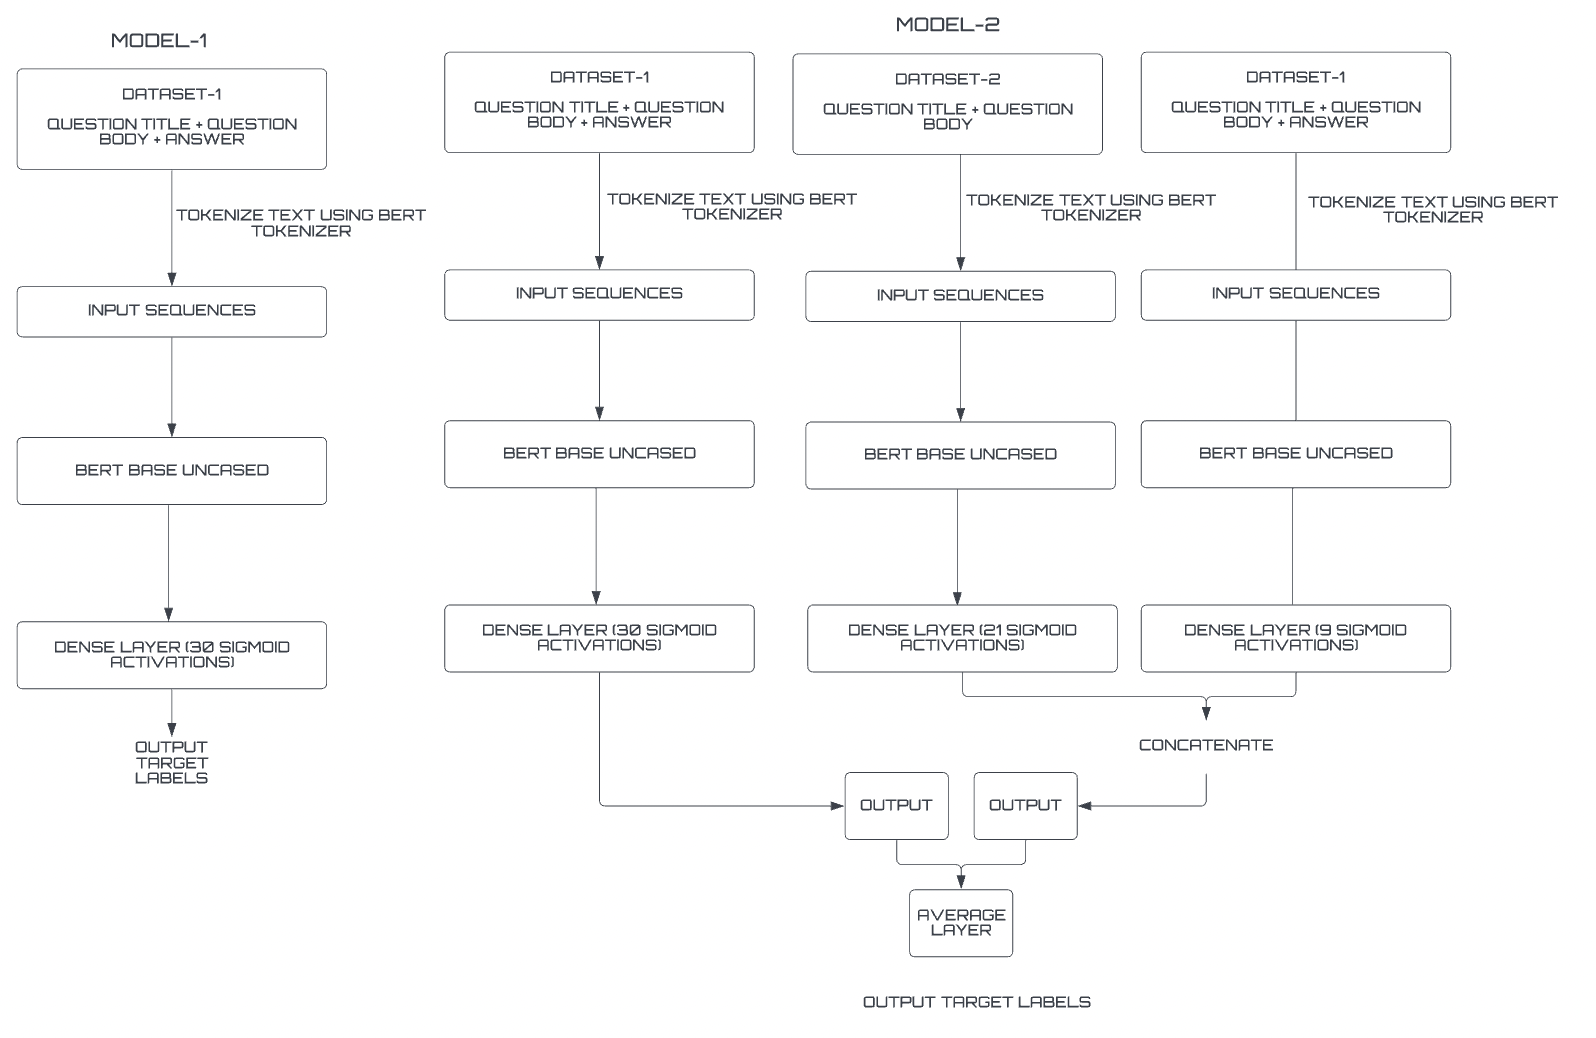

<h3>MODEL 1</h3>

In [ ]:
input_word_ids_dataset_1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids_dataset_1")
input_mask_dataset_1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask_dataset_1")
segment_ids_dataset_1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids_dataset_1")

bert_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_layer = TFBertModel.from_pretrained("bert-base-uncased", config = bert_config)

result = bert_layer([input_word_ids_dataset_1,input_mask_dataset_1,segment_ids_dataset_1])

# Last 4 hidden layers of bert
h12 = tf.reshape(result['hidden_states'][-1][:,0],(-1,1,768))
h11 = tf.reshape(result['hidden_states'][-2][:,0],(-1,1,768))
h10 = tf.reshape(result['hidden_states'][-3][:,0],(-1,1,768))
h09 = tf.reshape(result['hidden_states'][-4][:,0],(-1,1,768))
concat_hidden = tf.keras.layers.Concatenate(axis=2)([h12, h11, h10, h09])

x = GlobalAveragePooling1D()(concat_hidden)
x = Dense(30, activation='sigmoid')(x)
model = Model(inputs = [input_word_ids_dataset_1,input_mask_dataset_1,segment_ids_dataset_1], outputs = x, name = 'BERT_Google_Quest_Model_1')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "BERT_Google_Quest_Model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids_dataset_1 (Inpu  [(None, 512)]       0           []                               
 tLayer)                                                                                          
                                                                                                  
 input_mask_dataset_1 (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 segment_ids_dataset_1 (InputLa  [(None, 512)]       0           []                               
 yer)                                                                     

In [ ]:
train_data_q = {'input_word_ids_dataset_1': input_dataset_1, 'input_mask_dataset_1': mask_dataset_1, 'segment_ids_dataset_1': segment_dataset_1}
y_train_q = data.loc[:,data.columns[11:]]

In [ ]:
# Defining rhos metric
from scipy.stats import spearmanr
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

# making rhos tensorflow graph compatible
def rhos(y, y_pred):
    score =  tf.numpy_function(lambda y, y_pred : compute_spearmanr_ignore_nan(y, y_pred).astype('float32'),
                            [y, y_pred],
                            'float32',
                            name='rhos' )
    return score

<strong>MODEL PERFORMANCE USING LOG LOSS</strong>

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002), loss = 'binary_crossentropy',metrics = [rhos])
model.fit(train_data_q, y_train_q, epochs=5, batch_size=4, validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - ETA: 0s - loss: 0.3911 - rhos: 0.3178

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - 756s 541ms/step - loss: 0.3911 - rhos: 0.3178 - val_loss: 0.3723 - val_rhos: 0.3780
Epoch 2/5
1368/1368 [==============================] - 741s 542ms/step - loss: 0.3624 - rhos: 0.4257 - val_loss: 0.3644 - val_rhos: 0.4024
Epoch 3/5
1368/1368 [==============================] - 742s 542ms/step - loss: 0.3465 - rhos: 0.4806 - val_loss: 0.3691 - val_rhos: 0.4011
Epoch 4/5
1368/1368 [==============================] - 742s 543ms/step - loss: 0.3304 - rhos: 0.5449 - val_loss: 0.3770 - val_rhos: 0.4009
Epoch 5/5
1368/1368 [==============================] - 743s 543ms/step - loss: 0.3140 - rhos: 0.6006 - val_loss: 0.3807 - val_rhos: 0.4024


<strong>MODEL PERFORMANCE USING MEAN SQUARED ERROR</strong>

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002), loss = 'mean_squared_error',metrics = [rhos])
model.fit(train_data_q, y_train_q, epochs=5, batch_size=4, validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - ETA: 0s - loss: 0.0485 - rhos: 0.2940

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - 759s 544ms/step - loss: 0.0485 - rhos: 0.2940 - val_loss: 0.0425 - val_rhos: 0.3752
Epoch 2/5
1368/1368 [==============================] - 743s 543ms/step - loss: 0.0386 - rhos: 0.4053 - val_loss: 0.0402 - val_rhos: 0.3937
Epoch 3/5
1368/1368 [==============================] - 742s 543ms/step - loss: 0.0337 - rhos: 0.4541 - val_loss: 0.0400 - val_rhos: 0.3967
Epoch 4/5
1368/1368 [==============================] - 742s 542ms/step - loss: 0.0291 - rhos: 0.5007 - val_loss: 0.0407 - val_rhos: 0.3872
Epoch 5/5
1368/1368 [==============================] - 742s 543ms/step - loss: 0.0245 - rhos: 0.5483 - val_loss: 0.0427 - val_rhos: 0.3946


<h3>MODEL 2</h3>

In [ ]:
input_word_ids_dataset_1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids_dataset_1")
input_mask_dataset_1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask_dataset_1")
segment_ids_dataset_1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids_dataset_1")

input_word_ids_dataset_2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids_dataset_2")
input_mask_dataset_2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask_dataset_2")
segment_ids_dataset_2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids_dataset_2")

bert_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_layer= TFBertModel.from_pretrained("bert-base-uncased", config = bert_config)

result_dataset_1 = bert_layer([input_word_ids_dataset_1,input_mask_dataset_1,segment_ids_dataset_1])
result_dataset_2 = bert_layer([input_word_ids_dataset_2,input_mask_dataset_2,segment_ids_dataset_2])

# Last 4 hidden layers of bert
h12_dataset_1 = tf.reshape(result_dataset_1['hidden_states'][-1][:,0],(-1,1,768))
h11_dataset_1 = tf.reshape(result_dataset_1['hidden_states'][-2][:,0],(-1,1,768))
h10_dataset_1 = tf.reshape(result_dataset_1['hidden_states'][-3][:,0],(-1,1,768))
h09_dataset_1 = tf.reshape(result_dataset_1['hidden_states'][-4][:,0],(-1,1,768))
concat_hidden_dataset_1 = tf.keras.layers.Concatenate(axis=2)([h12_dataset_1, h11_dataset_1, h10_dataset_1, h09_dataset_1])
x_dataset_1 = GlobalAveragePooling1D()(concat_hidden_dataset_1)

# Last 4 hidden layers of bert_q
h12_dataset_2 = tf.reshape(result_dataset_2['hidden_states'][-1][:,0],(-1,1,768))
h11_dataset_2 = tf.reshape(result_dataset_2['hidden_states'][-2][:,0],(-1,1,768))
h10_dataset_2 = tf.reshape(result_dataset_2['hidden_states'][-3][:,0],(-1,1,768))
h09_dataset_2 = tf.reshape(result_dataset_2['hidden_states'][-4][:,0],(-1,1,768))
concat_hidden_dataset_2 = tf.keras.layers.Concatenate(axis=2)([h12_dataset_2, h11_dataset_2, h10_dataset_2, h09_dataset_2])
x_dataset_2 = GlobalAveragePooling1D()(concat_hidden_dataset_2)


x_question_answer = Dense(30, activation='sigmoid')(x_dataset_1)
x_answer = Dense(9, activation='sigmoid')(x_dataset_1)
x_question = Dense(21, activation='sigmoid')(x_dataset_2)
x_question_answer_seperate =  tf.keras.layers.Concatenate(axis=-1)([x_question,x_answer])
x_final = tf.keras.layers.Average()([x_question_answer, x_question_answer_seperate])

model = Model(inputs = [input_word_ids_dataset_1,input_mask_dataset_1,segment_ids_dataset_1,input_word_ids_dataset_2,input_mask_dataset_2,segment_ids_dataset_2], outputs = x_final, name = 'BERT_Google_Quest')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "BERT_Google_Quest"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids_dataset_1 (Inpu  [(None, 512)]       0           []                               
 tLayer)                                                                                          
                                                                                                  
 input_mask_dataset_1 (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 segment_ids_dataset_1 (InputLa  [(None, 512)]       0           []                               
 yer)                                                                             

In [ ]:
train_data_q = {'input_word_ids_dataset_1': input_dataset_1,
                'input_mask_dataset_1': mask_dataset_1,
                'segment_ids_dataset_1': segment_dataset_1,
                'input_word_ids_dataset_2': input_dataset_2,
                'input_mask_dataset_2': mask_dataset_2,
                'segment_ids_dataset_2': segment_dataset_2}
y_train_q = data.loc[:,data.columns[11:]]

In [ ]:
# Defining rhos metric
from scipy.stats import spearmanr
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

# making rhos tensorflow graph compatible
def rhos(y, y_pred):
    score =  tf.numpy_function(lambda y, y_pred : compute_spearmanr_ignore_nan(y, y_pred).astype('float32'),
                            [y, y_pred],
                            'float32',
                            name='rhos' )
    return score

<strong>MODEL PERFORMANCE USING LOG LOSS</strong>

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002), loss = 'binary_crossentropy',metrics = [rhos])
model.fit(train_data_q, y_train_q, epochs=5, batch_size=4, validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - ETA: 0s - loss: 0.3858 - rhos: 0.3330

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - 1466s 1s/step - loss: 0.3858 - rhos: 0.3330 - val_loss: 0.3708 - val_rhos: 0.3849
Epoch 2/5
1368/1368 [==============================] - 1429s 1s/step - loss: 0.3594 - rhos: 0.4408 - val_loss: 0.3656 - val_rhos: 0.4089
Epoch 3/5
1368/1368 [==============================] - 1428s 1s/step - loss: 0.3438 - rhos: 0.5012 - val_loss: 0.3710 - val_rhos: 0.4105
Epoch 4/5
1368/1368 [==============================] - 1429s 1s/step - loss: 0.3295 - rhos: 0.5486 - val_loss: 0.3752 - val_rhos: 0.4128
Epoch 5/5
1368/1368 [==============================] - 1424s 1s/step - loss: 0.3153 - rhos: 0.6030 - val_loss: 0.3832 - val_rhos: 0.4024


<strong>MODEL PERFORMANCE USING MEAN SQUARED ERROR</strong>

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002), loss = 'mean_squared_error',metrics = [rhos])
model.fit(train_data_q, y_train_q, epochs=5, batch_size=4, validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - ETA: 0s - loss: 0.0468 - rhos: 0.3243

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1368/1368 [==============================] - 1366s 976ms/step - loss: 0.0468 - rhos: 0.3243 - val_loss: 0.0424 - val_rhos: 0.3869
Epoch 2/5
1368/1368 [==============================] - 1333s 974ms/step - loss: 0.0375 - rhos: 0.4270 - val_loss: 0.0394 - val_rhos: 0.4079
Epoch 3/5
1368/1368 [==============================] - 1332s 974ms/step - loss: 0.0327 - rhos: 0.4730 - val_loss: 0.0396 - val_rhos: 0.4143
Epoch 4/5
1368/1368 [==============================] - 1332s 973ms/step - loss: 0.0286 - rhos: 0.5131 - val_loss: 0.0403 - val_rhos: 0.4185
Epoch 5/5
1368/1368 [==============================] - 1331s 973ms/step - loss: 0.0243 - rhos: 0.5592 - val_loss: 0.0414 - val_rhos: 0.4130


In [ ]:
from prettytable import PrettyTable
  
results = PrettyTable(["MODEL", "LOSS", "SPEARMAN's CORRELATION COEFFICIENT"])
  
results.add_row(["MODEL 1","LOG LOSS","0.4024"])
results.add_row(["MODEL 1","MSE","0.3946"])
results.add_row(["MODEL 2","LOG LOSS","0.4024"])
results.add_row(["MODEL 2","MSE","0.4130"])
print(results)

+---------+----------+------------------------------------+
|  MODEL  |   LOSS   | SPEARMAN's CORRELATION COEFFICIENT |
+---------+----------+------------------------------------+
| MODEL 1 | LOG LOSS |               0.4024               |
| MODEL 1 |   MSE    |               0.3946               |
| MODEL 2 | LOG LOSS |               0.4024               |
| MODEL 2 |   MSE    |               0.4130               |
+---------+----------+------------------------------------+
